# Tutorial 7 - Inverse PINN Problem

We have already worked a lot with PINNs and in the last tutorial we saw how to define a custom KAN class. In this tutorial we will be combining these to define a PINN that solves the so-called inverse problem.

In [1]:
from typing import List
from jaxkan.layers.Spline import SplineLayer

import jax
import jax.numpy as jnp

from jaxkan.utils.PIKAN import sobol_sample, gradf

from flax import nnx
import optax

import matplotlib.pyplot as plt
import numpy as np

## Data Generation

For the purposes of this example, we will be working with the Diffusion Equation,

$$ \frac{\partial u}{\partial t} -D \frac{\partial^2 u}{\partial x^2} = 0,$$

in the $\Omega = [0,1]\times [0,1]$ domain, subject to the boundary conditions

$$ u\left(t=0, x\right) = \sin\left(\pi x\right), $$

$$ u\left(t, x=0\right) = u\left(t, x=1\right) = 0. $$

We have intentionally left $D$ undefined, as we intend to also estimate it (apart from solving the PDE), using "experimental data". The PDE's analytical solution is given by

$$ u(t,x) = \sin\left(\pi x\right) \cdot \exp\left(-D\pi^2 t\right), $$

so it will be used to generate mock experimental data with gaussian noise for $D = 0.25$.

In [2]:
seed = 42

# Generate Collocation points for PDE
N = 2**12
collocs = jnp.array(sobol_sample(np.array([0,0]), np.array([1,1]), N, seed)) # (4096, 2)

# Generate Collocation points for BCs
N = 2**6

BC1_colloc = jnp.array(sobol_sample(np.array([0,0]), np.array([0,1]), N)) # (64, 2)
BC1_data = jnp.sin(np.pi*BC1_colloc[:,1]).reshape(-1,1) # (64, 1)

BC2_colloc = jnp.array(sobol_sample(np.array([0,0]), np.array([1,0]), N)) # (64, 2)
BC2_data = jnp.zeros(BC2_colloc.shape[0]).reshape(-1,1) # (64, 1)

BC3_colloc = jnp.array(sobol_sample(np.array([0,1]), np.array([1,1]), N)) # (64, 2)
BC3_data = jnp.zeros(BC3_colloc.shape[0]).reshape(-1,1) # (64, 1)

# Create lists for BCs
bc_collocs = [BC1_colloc, BC2_colloc, BC3_colloc]
bc_data = [BC1_data, BC2_data, BC3_data]

# Generate experimental data for inverse problem
def u(t,x,tau):
    return jnp.sin(jnp.pi*x)*jnp.exp(-tau*(jnp.pi**2)*t)

key = jax.random.PRNGKey(seed)
idxs = jax.random.choice(key, jnp.arange(collocs.shape[0]), (1000,), replace=False)
exp_collocs = collocs[idxs] # (1000, 2)

u_vals = u(exp_collocs[:,0], exp_collocs[:,1], 0.25).reshape(-1,1)
noise = u_vals.std()*jax.random.normal(key, shape=(1000,1))
exp_data = u_vals + noise # (1000, 1)

## KAN Model

Similar to the previous tutorial, we will define a KAN Class based on the Spline Layer, which will also include a trainable parameter, $\tau$.

In [3]:
class MyKAN(nnx.Module):
    
    def __init__(self, layer_dims: List[int], k: int = 3, G: int = 5, add_bias: bool = True, seed: int = 42):
        
        self.layers = [
                SplineLayer(
                    n_in=layer_dims[i], 
                    n_out=layer_dims[i + 1],
                    k=k,
                    G=G,
                    residual=nnx.silu,
                    external_weights=True,
                    add_bias=add_bias,
                    seed=seed)
                for i in range(len(layer_dims) - 1)
            ]

        # This is the parameter we need to identify to solve the inverse problem
        # We initialize it at 1.0
        self.tau = nnx.Param(jnp.array([1.0]))

    
    def __call__(self, x):

        for layer in self.layers:
            x = layer(x)

        return x

In [4]:
# Initialize a MyKAN model instance
n_in = collocs.shape[1]
n_out = 1
n_hidden = 6

layer_dims = [n_in, n_hidden, n_hidden, n_out]

model = MyKAN(layer_dims = layer_dims, k = 3, G = 5, add_bias = True, seed = 42)

## Training

PINNs provide a unified framework for solving the forward and the inverse PDE problem. Nonetheless, we will need to incorporate the "experimental" data in the loss function.

In [5]:
opt_type = optax.adam(learning_rate=0.001)

optimizer = nnx.Optimizer(model, opt_type)

In [6]:
# PDE Loss
def pde_loss(model, collocs):
    # Eq. parameter
    tau = model.tau.value

    def u(x):
        y = model(x)
        return y
        
    # Physics Loss Terms
    u_t = gradf(u, 0, 1)
    u_xx = gradf(u, 1, 2)
    
    # Residual
    pde_res = u_t(collocs) - tau*u_xx(collocs)
    
    return pde_res

# Define train loop
@nnx.jit
def train_step(model, optimizer, collocs, bc_collocs, bc_data, exp_collocs, exp_data):

    def loss_fn(model):
        pde_res = pde_loss(model, collocs)
        total_loss = jnp.mean((pde_res)**2)

        # Boundary losses
        for idx, colloc in enumerate(bc_collocs):
            # Residual = Model's prediction - Ground Truth
            residual = model(colloc) - bc_data[idx]
            # Loss
            total_loss += jnp.mean(residual**2)

        # Experimental data loss
        exp_pred = model(exp_collocs)
        total_loss += jnp.mean((exp_pred-exp_data)**2)

        return total_loss
    
    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    
    return loss

In [7]:
# Initialize train_losses
num_epochs = 5000

for epoch in range(num_epochs):
    # Calculate the loss
    loss = train_step(model, optimizer, collocs, bc_collocs, bc_data, exp_collocs, exp_data)

2025-11-23 10:59:00.328899: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-23 10:59:00.328944: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-23 10:59:00.328971: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-23 10:59:00.328979: W external/xla/xla/service/gpu/au

## Evaluation

The following plot shows the trained neural network on the entire domain, approximating the solution, $u$, of the equation.

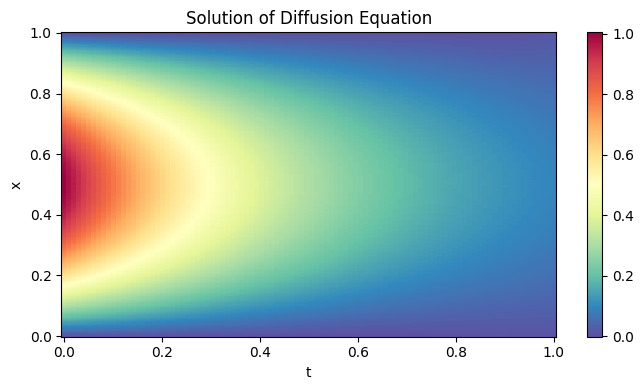

In [8]:
N_t, N_x = 100, 256

t = np.linspace(0.0, 1.0, N_t)
x = np.linspace(0.0, 1.0, N_x)
T, X = np.meshgrid(t, x, indexing='ij')
coords = np.stack([T.flatten(), X.flatten()], axis=1)

output = model(jnp.array(coords))
resplot = np.array(output).reshape(N_t, N_x)

plt.figure(figsize=(7, 4))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Solution of Diffusion Equation')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()

We can also visualize the difference between the analytical and the approximated solution.

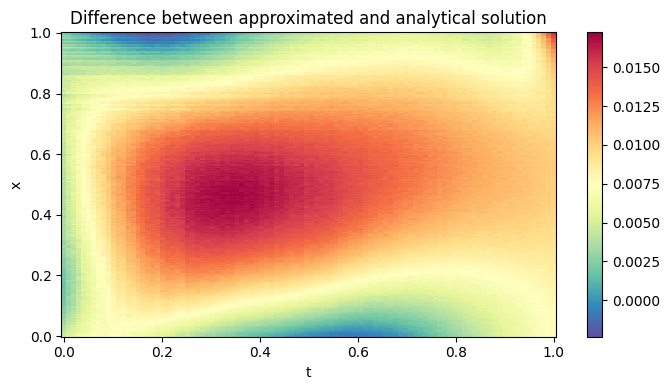

In [9]:
output = model(jnp.array(coords))
diff = output - u(coords[:,0], coords[:,1], 0.25).reshape(-1, 1)
resplot = np.array(diff).reshape(N_t, N_x)

plt.figure(figsize=(7, 4))
plt.pcolormesh(T, X, resplot, shading='auto', cmap='Spectral_r')
plt.colorbar()

plt.title('Difference between approximated and analytical solution')
plt.xlabel('t')

plt.ylabel('x')

plt.tight_layout()
plt.show()

It appears that the approximation is good, since the maximum absolute error is $\sim 0.02$.

Finally, we can see that $\tau$ is approximated quite well:

In [10]:
print(f"The approximated value for τ is {model.tau.value[0]}.")

The approximated value for τ is 0.24074824154376984.
